## Table of Contents
- [1. Introduction](#1-introduction)
- [2. Getting Data](#2-getting-data)
- [3. Processing Raw Data](#3-processing-raw-data)
- [4. choosing Images](#4-choosing-images)
- [5. Final Processing](#5-final-processing)
- [6. Training Model](#6-training-model)
- [7. Validation](#7-validation)

## 1. Introduction

- In this tutorial we go through the entire pipeline from downloading data, down to the model training and testing. 
- Please see the main README for general overview and instructions on how to set up a python environment and install the levee_hunter. 
- In this tutorial, code is executed from within the project's root directory, it is the directory inside which all the main subdirectories are located, such as levee_hunter, data or models.
- If you wish to locate your project root directory the cell below can be used:

In [1]:
from levee_hunter.paths import find_project_root

print(find_project_root())

/share/gpu5/pmucha/fathom/levee-hunter


## 2. Getting Data
- **NOTE**: this step can take a long time, if you wish to skip it, this data can be downloaded from: \
`/share/gpu5/pmucha/fathom/levee-hunter/data/raw/tutorial_data`

- **First, create directory** inside the raw/ which will hold the raw data for this tutorial. From within the project's root directory, run:

```bash
$ cd data/raw
$ mkdir tutorial_data
```

- Now we need to get some Lidar data. For that we can use download_lidar_data.py. Please see data_downloader/ for details

- We will proceed with the 1m data. For this the DATASET inside of download_lidar_data.py should be:

```python
DATASETS = ",".join(
    [
        # "National Elevation Dataset (NED) 1 arc-second Current",
        # "National Elevation Dataset (NED) 1/3 arc-second Current",
        # "National Elevation Dataset (NED) 1/9 arc-second",
        # "Original Product Resolution (OPR) Digital Elevation Model (DEM)",
        "Digital Elevation Model (DEM) 1 meter",  # need --cellSize 0.3
    ]
)
```

- Additionally make sure to change the LEVEE_PATH so that it points to the levees data you wish to use.


- Now we could run the script and for example create a task_list.txt with:

```bash
$ download-lidar -g --cellSize 0.2
```

- For this tutorial we will instead create a very short task_list.txt with the following task: 
```text
-121.86659435500243,38.39761436257408,-121.66659435500245,38.597614362574085
```

- **The task_list.txt** containing this single line should be inside the tutorial_data. For example it can be created with the cell below:

In [2]:
from pathlib import Path

lines = """-121.66659435500245,38.39761436257408,-121.46659435500246,38.597614362574085"""

# assuming it is ran from the tutorial/ or notebooks/ directory
# adjust the path to point to the correct location if needed
task_list_path = Path("../data/raw/tutorial_data/task_list.txt")
task_list_path.write_text(lines)

76

- Now we run the download_lidar_data.py on this task_list.txt. Note the data will be downloaded into `tutorial_data/Downloads` which will be created, but we will just move it.

- From within data/raw/tutorial_data:

```bash
$ download-lidar -l task_list.txt
```

- **Note**: this will download about 4 GB of data and might take some time to finish. For me it took almost 2 hours.

- Move downloaded images to the tutorial_data
```bash
$ cd Downloads
$ mv ./* /share/gpu5/pmucha/fathom/levee-hunter/data/raw/tutorial_data
```

- Now the downloaded data in .tif format, should be located in data/raw/tutorial_data

Example filename: `USGS_1M_10_x61y426_CA_SolanoCounty_A23.tif`

(1, 10012, 10012)


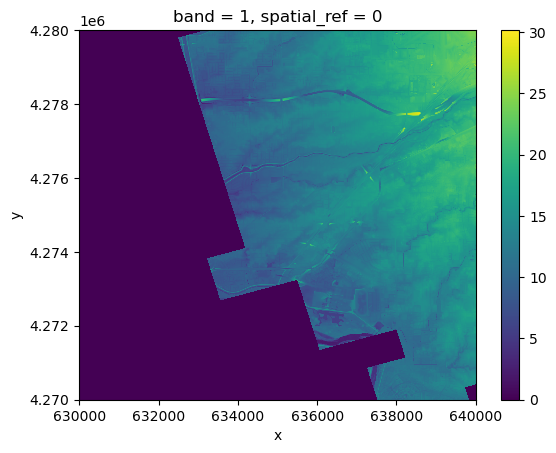

In [3]:
# plot an example image, note it might take a while to plot, for me it took around 2 minutes.
# There is a lot of invalid values so we replace them with 0
import rioxarray

example_img = rioxarray.open_rasterio('../data/raw/tutorial_data/USGS_1M_10_x63y428_CA_UpperSouthAmerican_Eldorado_2019_B19.tif')
example_img = example_img.where(example_img >= -9999, 0)
example_img.plot()

print(example_img.shape)

## 3. Processing Raw Data
- Now that we have raw data, we are ready to process it to intermediate. For that we will use the tutorial_config from `configs/processing.yaml`.

- **This process** splits original Lidar images (which are too large for model training) into smaller ones, removes invalid images and keeps only a fraction of empty images (images where there is only background).

- Please adjust the path to levees data in the configuration.

- We can run this as:

```bash
$ process-raw --config_name tutorial_config
```

- This step took about 2 minutes for me.

- The output should inform user where the new data has been saved, for example: \
`Saved images and masks at /share/gpu5/pmucha/fathom/levee-hunter/data/intermediate/tutorial_data/1m_544`

## 4. Choosing Images

**Because the levees database is not complete**, some images will be incorrectly labelled. They could confuse the model during training.

Currently levee_hunter allows user to make a choice for intermediate images manually:

1. Check if image considered overlaps with previously selected images, if it does, it is deleted.
2. If not, present it to the user, along with its mask.
3. User has an option to keep, mark as special, or remove an image
4. If user selects 'keep', image and its mask are moved to the data/processed, in accordance to the output_dir parameter.
5. If user selects 'special' image is moved similarly as for 'keep' but 'w2' is added to its filename, signifying that its weighting is higher.
6. If user selects 'remove' image and its mask are simply deleted.
7. User can safely quit at any point, no need to process all images at once.

This should allow the user to choose those images that can be safely used for training the model. For example to remove all images which seem to have non-labelled levees on them.

**Done in the cell below**:
Note: single keys can be pressed to: 
 - keep (a)
 - special (w)
 - remove (d)
 - quit (q)

Image passed overlap check.
Progress: 212/380 

Currently Processing: ../data/intermediate/tutorial_data/1m_544/images/8_2a07c91112.tif


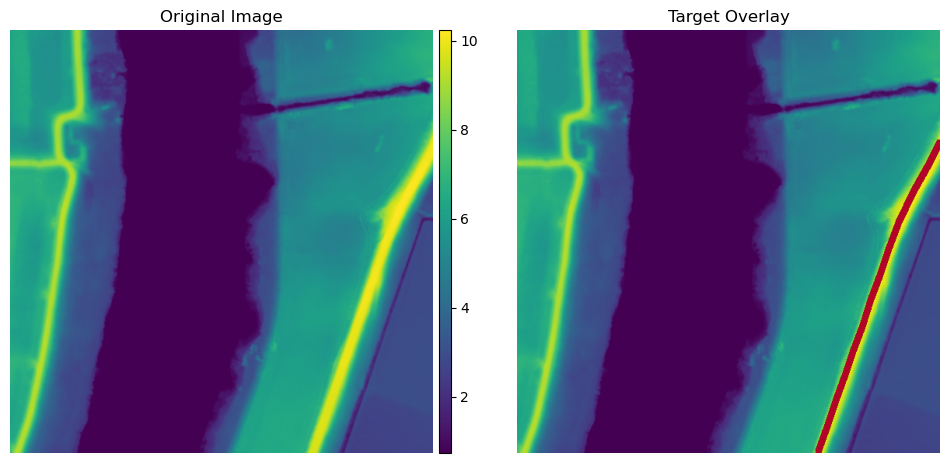

In [1]:
from levee_hunter.processing.dataset_images_choice import interactive_images_selection

# please note, the dilation_size is only for visualisation.
interactive_images_selection(
    intermediate_data_path="../data/intermediate/tutorial_data/1m_544",
    output_dir='../data/processed/tutorial_data/1m_544', 
    dilation_size=7, 
    figsize=(12, 6),
    cmap='viridis',
    plot_overlay=True
    )

Note: the dilation is just for visualisation, the masks saved inside processed, are not dilated, levees have 1 pixel width.

## 5. Final Processing

- **Now that we have reliable data**, we can use it to train our model. 

- 1. We create a LeveesDataset object, which will hold paths to out chosen images and masks. (See cell below)

- 2. We will dilate the levees (make the levee lines thicker)

- 3. We will select some 

**1. Create LeveesDataset Object**

In [1]:
from levee_hunter.levees_dataset import LeveesDataset

# create a dataset object
dataset = LeveesDataset(
    images_dir='../data/processed/tutorial_data/1m_544/images',
    masks_dir='../data/processed/tutorial_data/1m_544/masks',
    transform=None,
    weighted=True,
    )        

/home/pmucha/.conda/envs/fathom/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/pmucha/.conda/envs/fathom/lib/python3.11/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/share/gpu5/pmucha/fathom/levee-hunter/levee_hunter/augmentations.py:17: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(
/share/gpu5/pmucha/fathom/levee-hunter/levee_hunter/augmentations.py:20: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(
/share/gpu5/pmucha/fathom/levee-hu

- LeveesDataset has some very useful methods and attributes:

In [2]:
# list attributes of the dataset object
vars(dataset).keys()

dict_keys(['images_dir', 'masks_dir', 'img_paths', 'mask_paths', 'transform', 'weighted', 'weights'])

In [3]:
# we can get file_ids 
set(dataset.file_ids)

{'0f9dcecd66',
 '228893aeeb',
 '2a07c91112',
 '369745f3df',
 '4e7e7d0aed',
 '624762119d',
 '79ca9e90f0',
 '9e050c77a1',
 '9e6751e55a',
 'a11d6e4b66',
 'b3645fc877',
 'be47257a41',
 'c2b345eace',
 'c56d9b8742'}

In [4]:
# It does not store the images themselves, but rather paths to them (and to masks)
dataset.img_paths[:5]

[PosixPath('../data/processed/tutorial_data/1m_544/images/0_0f9dcecd66_w1.tif'),
 PosixPath('../data/processed/tutorial_data/1m_544/images/0_228893aeeb_w1.tif'),
 PosixPath('../data/processed/tutorial_data/1m_544/images/0_369745f3df_w1.tif'),
 PosixPath('../data/processed/tutorial_data/1m_544/images/0_4e7e7d0aed_w1.tif'),
 PosixPath('../data/processed/tutorial_data/1m_544/images/0_624762119d_w1.tif')]

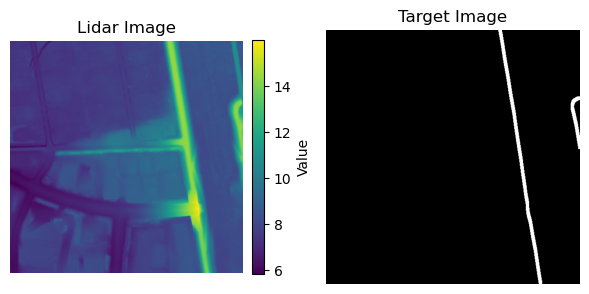

In [5]:
dataset.plot(idx=0, figsize=(6, 3), cmap='viridis', transform=False)

**2. Apply Dilation** 
We make the levee lines thicker by dilating them on the masks, see in the cell below, and plot to see how it changed the masks:

In [6]:
dataset.apply_mask_type(mask_type='dilated', dilation_size=7)

Processing masks: 100%|██████████| 159/159 [00:02<00:00, 56.99it/s]


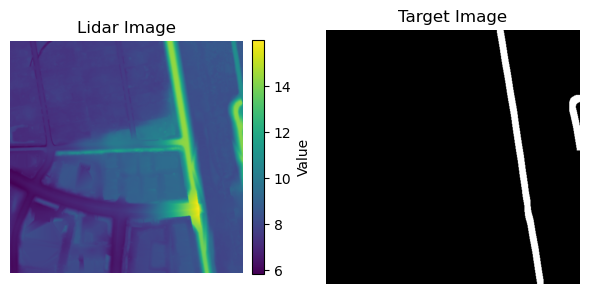

In [7]:
dataset.plot(idx=0, figsize=(6, 3), cmap='viridis', transform=False)

**3. Validation Dataset**

Now based on the file IDs we will create a separate LeveesDataset object, which will hold validation images only. Those images will be deleted from the original LeveesDataset object.

Note: file IDs tell us from which original raw .tif file, given image came from, this allows for example to choose a certain area for validation only, and not for training.

In [8]:
# file_ids of the images we want to use for validation
# we choose the first three of them 
file_ids = ['228893aeeb', '369745f3df', '4e7e7d0aed']

In [9]:
from levee_hunter.train_test_val_splitting import validation_split

dataset, val_dataset = validation_split(dataset=dataset, file_ids=file_ids)

len(dataset), len(val_dataset)

(124, 35)

**4. Train Test Split**

Now the rest of the dataset we are left with, after splitting for validation, we will split further into train and test LeveeDataset objects:

In [10]:
from levee_hunter.train_test_val_splitting import train_test_split_dataset

train_dataset, test_dataset = train_test_split_dataset(dataset=dataset, test_size=0.2)

In [11]:
len(train_dataset), len(test_dataset), len(val_dataset)

(99, 25, 35)

In [12]:
# we can check if their transformations are what we want them to be
train_dataset.transform, test_dataset.transform, val_dataset.transform

('train_transform', 'normalize_only', 'normalize_only')

In [13]:
# test and validation should be unweighted
test_dataset.weighted=False
val_dataset.weighted=False

**5. Create Data Loaders**

In [14]:
import torch
from torch.utils.data import DataLoader

batch_size = 12

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 6. Training Model

We are now ready to train a segmentation model, we will use the famous Unet.

In [27]:
import segmentation_models_pytorch as smp
import torch.optim as optim

model = smp.Unet(
    encoder_name="resnet34", encoder_weights="imagenet", in_channels=1, classes=1
).to(device)


optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [28]:
import torch.nn as nn

from levee_hunter.modeling.train import train_model

model, train_loss, val_loss = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    criterion=nn.BCEWithLogitsLoss(reduction="none"),
    epochs=50,
    save_model='best',
    save_model_path="../models/tutorial_models/Unet-1m_544.pth",
)

beginning training on device: cuda
Epoch: 1/50 Train Loss: 0.546841 Val Loss: 0.624458
Model successfully saved to: ../models/tutorial_models/Unet-1m_544.pth
Epoch: 2/50 Train Loss: 0.411155 Val Loss: 0.496732
Model successfully saved to: ../models/tutorial_models/Unet-1m_544.pth
Epoch: 3/50 Train Loss: 0.336636 Val Loss: 0.385902
Model successfully saved to: ../models/tutorial_models/Unet-1m_544.pth
Epoch: 4/50 Train Loss: 0.318726 Val Loss: 0.304426
Model successfully saved to: ../models/tutorial_models/Unet-1m_544.pth
Epoch: 5/50 Train Loss: 0.255370 Val Loss: 0.272768
Model successfully saved to: ../models/tutorial_models/Unet-1m_544.pth
Epoch: 6/50 Train Loss: 0.246952 Val Loss: 0.245379
Model successfully saved to: ../models/tutorial_models/Unet-1m_544.pth
Epoch: 7/50 Train Loss: 0.216629 Val Loss: 0.221624
Model successfully saved to: ../models/tutorial_models/Unet-1m_544.pth
Epoch: 8/50 Train Loss: 0.196968 Val Loss: 0.198987
Model successfully saved to: ../models/tutorial_mode

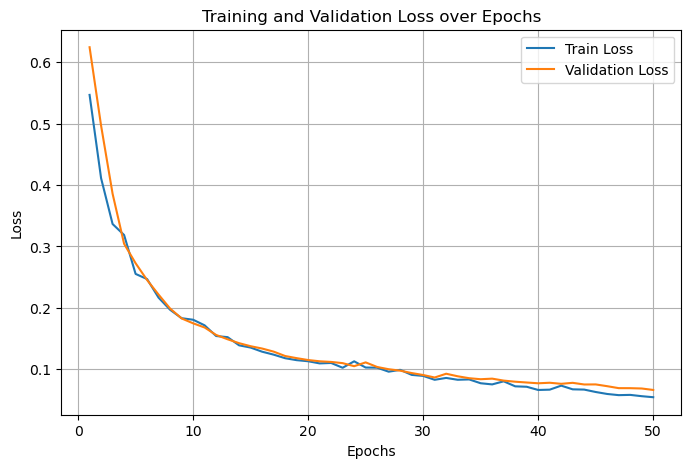

In [29]:
from levee_hunter.plots import plot_training_validation_loss
plot_training_validation_loss(train_loss[:], val_loss[:])

In [30]:
# load the saved model
model.load_state_dict(torch.load("../models/tutorial_models/Unet-1m_544.pth"))
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

0


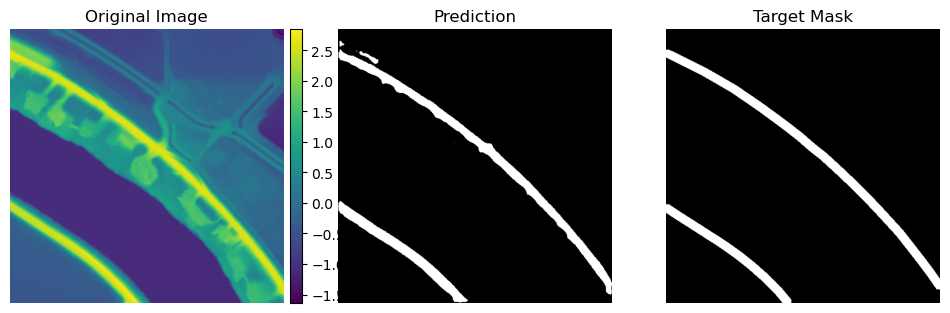

1


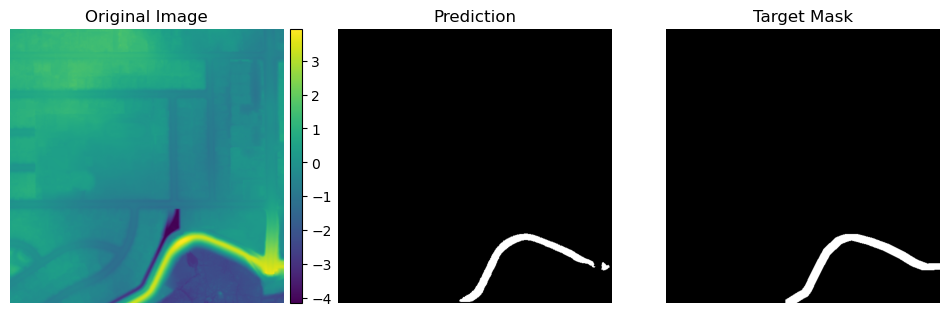

2


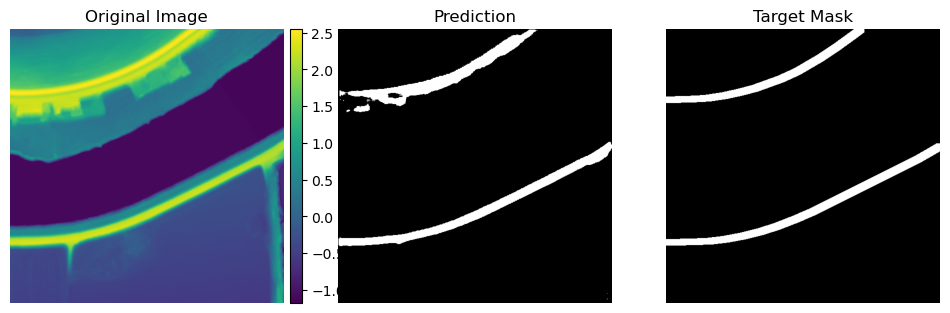

3


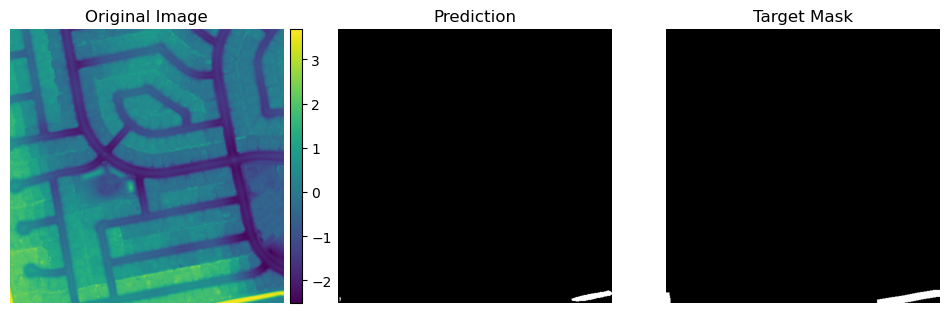

4


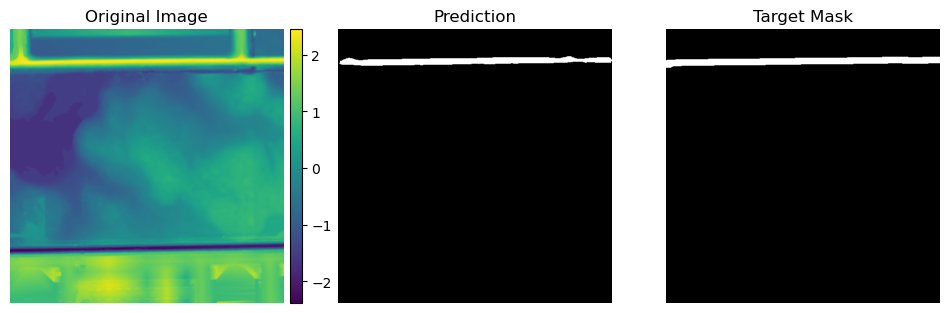

In [31]:
from levee_hunter.plots import infer_and_visualize
for ix in range(5):
    sample_image, sample_mask = test_dataset[ix]
    print(ix)
    output = infer_and_visualize(model, sample_image, sample_mask, apply_sigmoid=True, device=device)

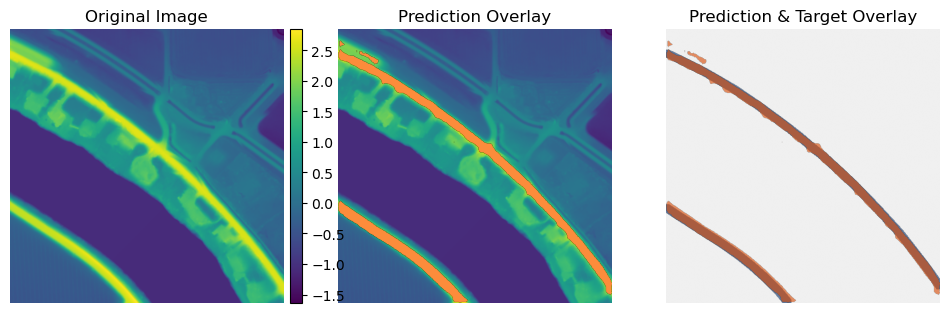

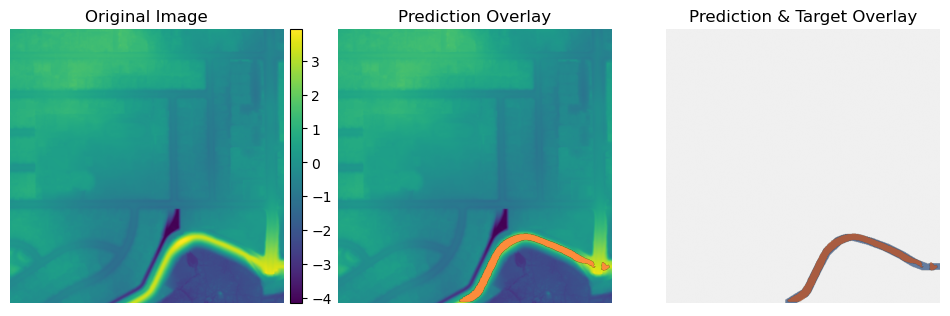

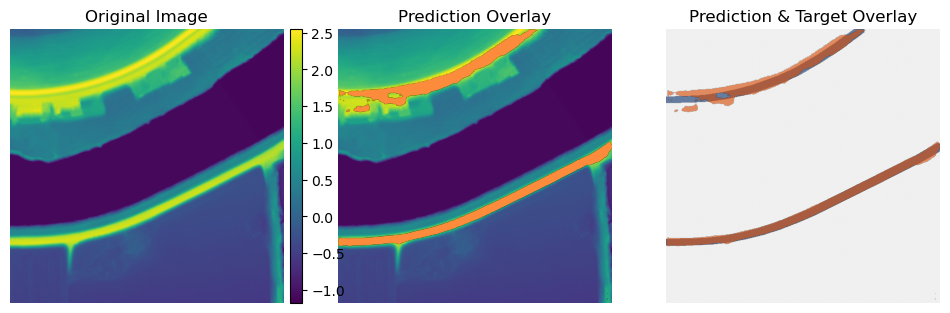

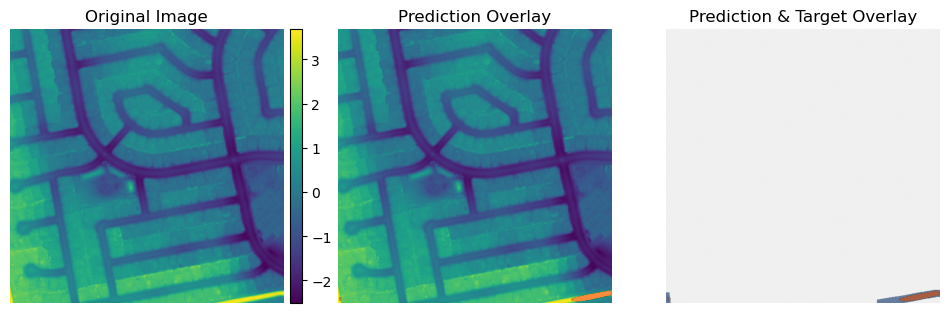

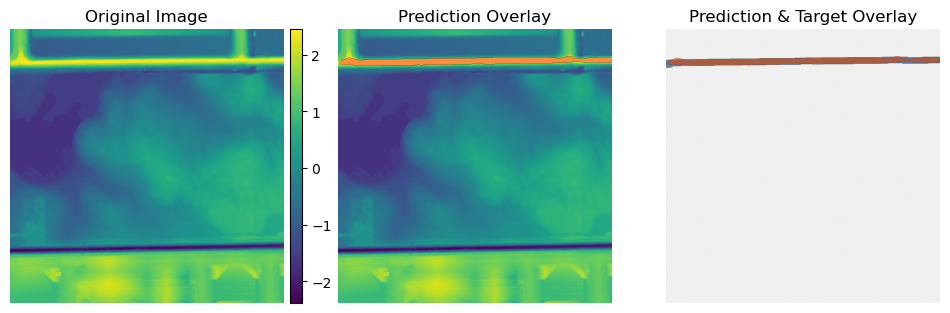

In [32]:
from levee_hunter.plots import infer_and_plot_overlap


for ix in range(5):
    img, target = test_dataset[ix]
    output = infer_and_plot_overlap(
        model=model, 
        image_tensor=img, 
        mask_tensor=target, 
        device=device, apply_sigmoid=True, 
        threshold=0.5, 
        invert=True
        )

# 7. Validation

We now can run metrics to check how our model is doing.

In [33]:
from levee_hunter.modeling.inference import get_preds_targets

all_preds, all_targets = get_preds_targets(model, test_loader, device=device)

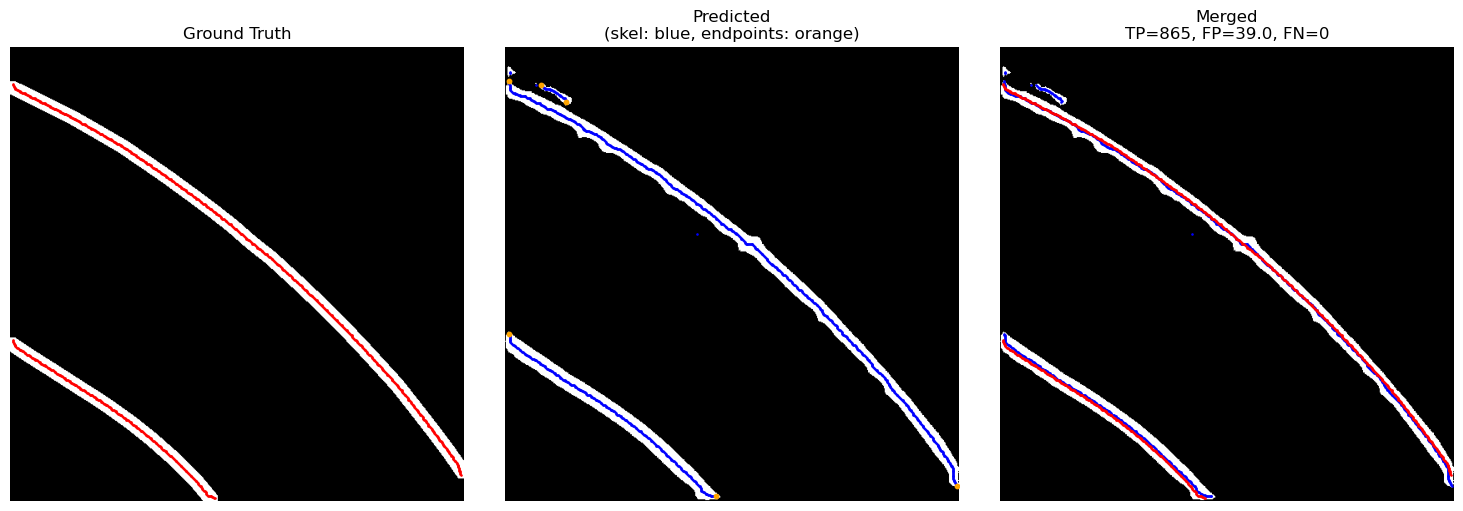

In [34]:
from levee_hunter.modeling.metrics import get_pred_mask, plot_skeletons, custom_metrics, standard_metrics

i = 0
pred_mask, target_mask = get_pred_mask(all_preds, all_targets, i)

plot_skeletons(pred_mask, d=13, d_merge=16, gt_mask=target_mask)

In [35]:
custom_metrics(targets=all_targets, predictions=all_preds, d=13, d_merge=16)

-----------------------Custom Metrics-----------------------
IoU Score:         0.7829
F1 Score (Dice):   0.8782
Recall:            0.8249
------------------------------------------------------------


In [37]:
standard_metrics(targets=all_targets, predictions=all_preds, threshold=0.5)

----------------------Standard Metrics----------------------
IoU Score:         0.6743
F1 Score (Dice):   0.8055
Accuracy:          0.9879
Recall:            0.7383
------------------------------------------------------------
